In [1]:
# prepares the notebook for "inline" graphing, and imports matplotlib library
%matplotlib inline
%config InlineBackend.figure_format='svg'
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from matplotlib.colors import LinearSegmentedColormap
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

from os import listdir
from os.path import isfile, join

In [2]:
# this is the folder where the NB02 data is stored on your computer
basePath = r'C:\Users\Ted Mburu\NbO2'

# these functions are used in determining the type
# of data we are looking at (posthesh, neghold etc)
def isIncreasing(L):
    return L[0] < L[len(L) - 1]
def isDecreasing(L):
    return L[0] > L[len(L) - 1]
def non_increasing(L):
    return all(x>=y for x, y in zip(L, L[1:]))
def non_decreasing(L):
    return all(x<=y for x, y in zip(L, L[1:]))
def monotonic(L):
    return non_increasing(L) or non_decreasing(L)
def average(array):
    return sum(array) / len(array)

# this will return the type of data you give it
# it takes an array of voltages and currents as arguments
def sortIntoSide(voltage, current):
    if isIncreasing(voltage) and isIncreasing(current):
        return "posThresh"
    elif isDecreasing(voltage) and isDecreasing(current):
        return "posHold"
    elif isDecreasing(voltage) and isIncreasing(current):
        return "negThresh"
    elif isIncreasing(voltage) and isDecreasing(current):
        return "negHold"
    else: 
        print("???")


# this will take a file name and device size and
# get all of the meaningful stuff out of it
class DataFile:
    def __init__(self, size, fileName):
        self.size = size
        
        if "Sam" in fileName:
            self.version = 2
        else:
            self.version = 1
        
        self.getFileName(fileName) # adds .txt to the file name
        self.getFileDate() # gets the date the data was taken from filename
        self.getSampleNumber() # gets the sample number from filename
        self.getDeviceNumber() # gets the device number from filename
        self.getDoping() # gets the doping percentage from filename
        
        self.NbPercentage = (100 - self.doping) / 100
        self.TiPercentage = self.doping / 100
        self.NbPercentageString = str(self.NbPercentage)
        self.TiPercentageString = str(self.TiPercentage)
        
        # the text displaed on graphs
        sampleText = '  Sample ' + str(self.sampleNumber)
        deviceText = '  Device ' + str(self.deviceNumber)
        nb = 'Nb' if self.NbPercentageString == "1.0" else r'Nb$_{'+ self.NbPercentageString +'}$'
        ti = '' if self.TiPercentageString == "0.0" else r'Ti$_{'+ self.TiPercentageString +'}$'
        self.title = nb + ti + r'O$_2$ 2x2 $\mu$m$^2$,' + sampleText + deviceText
        
        
        self.filePath = self.getFilePath() # combines the filename and base path to get file path
        self.getData() # reads the file and stores the current, voltage and time
        self.removeBadData() # removes all data before the device is burned through
        self.findAllIndexes() # gets the indexes that begin and end every run
        self.sortRuns() # sorts runs into their types and stores them
        self.getLargestGradients() # finds the index of the largest second derivative in each run
        self.getLargestGradientVoltage() # stores the voltage at the largest second derivative
        self.getLargestGradientCurrent() # stores the current at the largest second derivative
#         self.printData() # prints all the important data
#         self.showFinalGraph() # shows a graph with the important data highlighted

    # adds .txt to the file name
    def getFileName(self, fileName):
        self.fileName = fileName + r'.txt'
    
    # combines the filename and base path to get file path
    def getFilePath(self):
        filePath = ''
        if (self.doping  == 5):
            filePath = basePath + r'\Doping05\ '.rstrip()
        elif (self.doping  == 10):
            filePath = basePath + r'\Doping10\ '.rstrip()
        else: 
            filePath = basePath + r'\Doping0\ '.rstrip() 
        filePath = filePath + self.fileName
        return filePath
    
    # gets the date the data was taken from filename
    def getFileDate(self):
        if self.version == 1:
            dateMeasured = self.fileName.split("-")[1]
            self.dateMeasuredText = dateMeasured[:2] + '/' + dateMeasured[2:4] + "/" + dateMeasured[4:]
        elif self.version == 2:
            dateMeasured = self.fileName.split("Sam")[1].split("_")[1]
            self.dateMeasuredText = dateMeasured[:2] + '/' + dateMeasured[2:4] + "/20" + dateMeasured[4:]
        self.dateMeasured = dateMeasured
        
    # gets the sample number from filename
    def getSampleNumber(self):
        sampleNumber = self.fileName.split("_")[1].split("-")[0]
        self.sampleNumber = sampleNumber
        
    # gets the doping percentage from filename
    def getDoping(self): 
        # the two versions are the filenames with "Sam" in them and the rest
        if self.version == 1: 
            doping = self.fileName.split("IVNb")[1].split("Ti")[0]
            if doping == "1p00":
                doping = 0
            elif doping == "0p100":
                doping = 0
            elif doping == "0p95":
                doping = 5
            elif doping == "0p90":
                doping = 10
            else: 
                print("???")
        elif self.version == 2:
            doping = self.fileName.split("Ti")[1].split("_")[0]
        else:
            print("version?")
        self.doping = int(doping)
        
    # gets the device number from filename
    def getDeviceNumber(self): 
        if self.version == 1:
            deviceNumber = self.fileName[:-4].split(self.dateMeasured)[1].split("-")[1]
            self.deviceNumber = deviceNumber[1:]
        elif self.version == 2:
            deviceNumber = self.fileName[:-4].split(self.dateMeasured)[1].split("_")[1]
            self.deviceNumber = deviceNumber[1:]
    
    # reads the file and stores the current, voltage and time
    def getData(self):
        df5 = pd.read_csv(self.filePath, names=['Time (s)','Current (A)','Voltage (V)'],sep='\t',skiprows=1)
        data = df5.values
        df5.head()
        self.t = data[:,0]
        self.I = data[:,1]
        self.V = data[:,2]
    
    # removes all data before the device is burned through
    def removeBadData(self):
        largestCurrent = np.amax(self.I)
        maxCurrentThreshhold = largestCurrent * 0.80
        indexOfFirstLargeCurrent = np.argmax(self.I > maxCurrentThreshhold)
        self.indexOfFirstLargeCurrent = indexOfFirstLargeCurrent
        
        self.t= self.t[indexOfFirstLargeCurrent:]
        self.I= self.I[indexOfFirstLargeCurrent:]
        self.V= self.V[indexOfFirstLargeCurrent:]
        self.maxCurrentThreshhold = maxCurrentThreshhold
    
    # gets the indexes that begin and end every run
    def findAllIndexes(self):
        allZeroIndexes = []
        zeroIndexes = []
        allMaxIndexes = []
        maxIndexes = []
        newMaxIndexes = []
        allIndexes = []

        # indexes of values that are pretty much 0
        self.zeroThreshhold = 1e-5
        for index, x in enumerate(self.I):
            if x < self.zeroThreshhold:
                allZeroIndexes.append(index)

        # find the zero values that begin or end a run
        zeroIndexes.append(allZeroIndexes[0])
        for x in range(len(allZeroIndexes) - 1):
            if allZeroIndexes[x]+1 != allZeroIndexes[x+1]:
                zeroIndexes.append(allZeroIndexes[x])
                zeroIndexes.append(allZeroIndexes[x+1])
    
        for index, x in enumerate(self.I):
            if x > self.maxCurrentThreshhold:
                allMaxIndexes.append(index)

        # find the max values that start or end a run
        for x in range(len(allMaxIndexes) - 1):
            if allMaxIndexes[x]+1 != allMaxIndexes[x+1]:
                maxIndexes.append(allMaxIndexes[x])
                maxIndexes.append(allMaxIndexes[x+1])
                
        for x in range(len(allMaxIndexes) - 1):
            if allMaxIndexes[x]+1 != allMaxIndexes[x+1]:
                newMaxIndexes.append(allMaxIndexes[x]+1)
                newMaxIndexes.append(allMaxIndexes[x+1]+1)
        
        allIndexes = [*zeroIndexes, *maxIndexes]
        allIndexes = sorted(allIndexes)

        for x in range(3, len(allIndexes) - 1, 4):
            allIndexes[x] = allIndexes[x] + 1

        goodRuns = []
        for x in range(0, len(allIndexes) - 4, 4):
            if monotonic( self.V[allIndexes[x]:allIndexes[x+3]] ):
                goodRuns.append(allIndexes[x])
                goodRuns.append(allIndexes[x+1])
                goodRuns.append(allIndexes[x+2])
                goodRuns.append(allIndexes[x+3])

        allIndexes = np.copy(goodRuns)

        self.goodIndex = self.indexOfFirstLargeCurrent + allIndexes[0]

        self.allIndexes = allIndexes
        self.zeroIndexes = zeroIndexes
        
    # sorts runs into their types and stores them
    def sortRuns(self):
        posThreshValues = []
        negThreshValues = []
        posHoldValues = []
        negHoldValues = []

        timesToLoop = len(self.zeroIndexes) - 1
        for x in range(0, timesToLoop, 2):
            voltageRun = []
            currentRun = []
            timeRun = []
            secondDerivativeRun = []
            start = self.allIndexes[x]
            stop = self.allIndexes[x+1]
            if x >= self.goodIndex: 
                for y in range(start, stop):
                    voltageRun.append(self.V[y])
                    currentRun.append(self.I[y])
                    timeRun.append(self.t[y])
                    secondDerivativeRun.append(self.I[y])
                if len(currentRun) > 4:
                    secondDerivativeCurrent = np.gradient(np.gradient(currentRun))
                    runType = sortIntoSide(voltageRun, currentRun)
                    currentRun = [ abs(x) for x in currentRun]
                    runData = [timeRun, voltageRun, currentRun, secondDerivativeCurrent]
                    if (runType == "posThresh"):
                        posThreshValues.append(runData)
                    elif (runType == "posHold"):
                        posHoldValues.append(runData)
                    elif (runType == "negThresh"):
                        negThreshValues.append(runData)
                    elif (runType == "negHold"):
                        negHoldValues.append(runData)
        self.posThreshValues = posThreshValues
        self.negThreshValues = negThreshValues
        self.posHoldValues = posHoldValues
        self.negHoldValues = negHoldValues
    
    # finds the index of the largest second derivative in each run
    def getLargestGradients(self):
        # take second derivative of each current array
        posThreshValuesGradients = []
        negThreshValuesGradients = []
        posHoldValuesGradients = []
        negHoldValuesGradients = []

        for x in self.posThreshValues:
            posThreshValuesGradients.append(x[3])
        for x in self.negThreshValues:
            negThreshValuesGradients.append(x[3])
        for x in self.posHoldValues:
            posHoldValuesGradients.append(x[3])
        for x in self.negHoldValues:
            negHoldValuesGradients.append(x[3])
            
        self.posThreshValuesGradients = posThreshValuesGradients
        self.negThreshValuesGradients = negThreshValuesGradients
        self.posHoldValuesGradients = posHoldValuesGradients
        self.negHoldValuesGradients = negHoldValuesGradients

        # find the index of the largest value in the 2nd derivative
        posThreshValuesLargestGradient = []
        negThreshValuesLargestGradient = []
        posHoldValuesLargestGradient = []
        negHoldValuesLargestGradient = []

        for x in posThreshValuesGradients:
            largestValue = np.argmax(np.absolute(x[1:len(x) - 1])) + 1
            posThreshValuesLargestGradient.append(largestValue)
        for x in negThreshValuesGradients:
            largestValue = np.argmax(np.absolute(x[1:len(x) - 1])) + 1
            negThreshValuesLargestGradient.append(largestValue)
        for x in posHoldValuesGradients:
            largestValue = np.argmax(np.absolute(x[1:len(x) - 1])) + 1
            posHoldValuesLargestGradient.append(largestValue)
        for x in negHoldValuesGradients:
            largestValue = np.argmax(np.absolute(x[1:len(x) - 1])) + 1
            negHoldValuesLargestGradient.append(largestValue)
            
        self.posThreshValuesLargestGradient = posThreshValuesLargestGradient
        self.negThreshValuesLargestGradient = negThreshValuesLargestGradient
        self.posHoldValuesLargestGradient = posHoldValuesLargestGradient
        self.negHoldValuesLargestGradient = negHoldValuesLargestGradient
    
    # stores the voltage at the largest second derivative
    def getLargestGradientVoltage(self):
        posThreshValuesVoltage = []
        negThreshValuesVoltage = []
        posHoldValuesVoltage = []
        negHoldValuesVoltage = []

        for x in range(len(self.posThreshValuesGradients)):
            voltage = self.posThreshValues[x][1][self.posThreshValuesLargestGradient[x]]
            if abs(voltage) > 0.4 and abs(voltage) < 1:
                posThreshValuesVoltage.append(voltage)
        for x in range(len(self.negThreshValuesGradients)):
            voltage = self.negThreshValues[x][1][self.negThreshValuesLargestGradient[x]]
            if abs(voltage) > 0.4 and abs(voltage) < 1:
                negThreshValuesVoltage.append(voltage)
        for x in range(len(self.posHoldValuesGradients)):
            voltage = self.posHoldValues[x][1][self.posHoldValuesLargestGradient[x]]
            if abs(voltage) > 0.4 and abs(voltage) < 1:
                posHoldValuesVoltage.append(voltage)
        for x in range(len(self.negHoldValuesGradients)):
            voltage = self.negHoldValues[x][1][self.negHoldValuesLargestGradient[x]]
            if abs(voltage) > 0.4 and abs(voltage) < 1:
                negHoldValuesVoltage.append(voltage)
        
        self.posThreshValuesVoltage = posThreshValuesVoltage
        self.negThreshValuesVoltage = negThreshValuesVoltage
        self.posHoldValuesVoltage = posHoldValuesVoltage
        self.negHoldValuesVoltage = negHoldValuesVoltage
        
    # stores the current at the largest second derivative
    def getLargestGradientCurrent(self):
        posThreshValuesCurrent = []
        negThreshValuesCurrent = []
        posHoldValuesCurrent = []
        negHoldValuesCurrent = []

        for x in range(len(self.posThreshValuesGradients)):
            current = self.posThreshValues[x][2][self.posThreshValuesLargestGradient[x]]
            posThreshValuesCurrent.append(current)
        for x in range(len(self.negThreshValuesGradients)):
            current = self.negThreshValues[x][2][self.negThreshValuesLargestGradient[x]]
            negThreshValuesCurrent.append(current)
        for x in range(len(self.posHoldValuesGradients)):
            current = self.posHoldValues[x][2][self.posHoldValuesLargestGradient[x]]
            posHoldValuesCurrent.append(current)
        for x in range(len(self.negHoldValuesGradients)):
            current = self.negHoldValues[x][2][self.negHoldValuesLargestGradient[x]]
            negHoldValuesCurrent.append(current)
        
        self.posThreshValuesCurrent = posThreshValuesCurrent
        self.negThreshValuesCurrent = negThreshValuesCurrent
        self.posHoldValuesCurrent = posHoldValuesCurrent
        self.negHoldValuesCurrent = negHoldValuesCurrent
    
    # prints all the important data
    def printData(self):
        averages = []
        averages[0] = average(self.posThreshValuesVoltage)
        averages[1] = average(self.negThreshValuesVoltage)
        averages[2] = average(self.posHoldValuesVoltage)
        averages[3] = average(self.negHoldValuesVoltage)
        
        standardDeviations = []
        standardDeviations[0] = np.std(self.posThreshValuesVoltage)
        standardDeviations[1] = np.std(self.negThreshValuesVoltage)
        standardDeviations[2] = np.std(self.posHoldValuesVoltage)
        standardDeviations[3] = np.std(self.negHoldValuesVoltage)
        
        print("Positive Threshold Voltage: ", averages[0] , "Standard Deviation: ", standardDeviations[0])
        print("Negative Threshold Voltage: ", averages[1], "Standard Deviation: ", standardDeviations[1])
        print("Positive Hold Voltage: ", averages[2], "Standard Deviation: ", standardDeviations[2])
        print("Negative Hold Voltage: ", averages[3], "Standard Deviation: ", standardDeviations[3])
        print()
        
    # shows a graph with the important data highlighted
    def showFinalGraph(self):
        plt.rcParams['figure.figsize'] = (11,6)
        plt.figure(len(files))
        plt.grid()
        plt.semilogy(self.V, self.I)
        plt.xlabel('Voltage (V)');
        plt.ylabel('Current (A)');

        plt.axhline(y=self.maxCurrentThreshhold, color='r', linestyle='-')
        plt.axhline(y=self.zeroThreshhold, color='r', linestyle='-')

        if len(self.posThreshValuesVoltage) > 1:
            voltage = average(self.posThreshValuesVoltage)
            current = average(self.posThreshValuesCurrent)
            plt.errorbar(voltage, current, xerr=np.std(self.posThreshValuesVoltage), fmt="ro")

        if len(self.negThreshValuesVoltage) > 1:
            voltage = average(self.negThreshValuesVoltage)
            current = average(self.negThreshValuesCurrent)
            plt.errorbar(voltage, current, xerr=np.std(self.negThreshValuesVoltage), fmt="bo")

        if len(self.posHoldValuesVoltage) > 1:
            voltage = average(self.posHoldValuesVoltage)
            current = average(self.posHoldValuesCurrent)
            plt.errorbar(voltage, current, xerr=np.std(self.posHoldValuesVoltage), fmt="go")

        if len(self.negHoldValuesVoltage) > 1:
            voltage = average(self.negHoldValuesVoltage)
            current = average(self.negHoldValuesCurrent)
            plt.errorbar(voltage, current, xerr=np.std(self.negHoldValuesVoltage), fmt="yo")

        plt.title(self.title);




In [3]:
files = [] # stores all the files data as DataFile objects

# creating the objects as indices in the files array
#                     size, fileName
# files.append(DataFile("3x3", r'IVs_NbO2_Ti10_Sam13_060622_10a'))
files.append(DataFile("2x2", r'IVs_NbO2_Ti10_Sam13_060622_11b'))
files.append(DataFile("2x2", r'IVs_NbO2_Ti10_Sam13_060622_12a'))
files.append(DataFile("2x2", r'IVs_NbO2_Ti10_Sam24_051722_D1'))
# files.append(DataFile("2x2", r'IVs_NbO2_Ti10_Sam24_051922_D2'))
# files.append(DataFile("3x3", r'IVs_NbO2_Ti10_Sam24_051922_D3'))
# files.append(DataFile("3x3", r'IVs_NbO2_Ti10_Sam24_051922_D4'))
files.append(DataFile("4x4", r'IVs_NbO2_Ti10_Sam24_051922_D5'))
# files.append(DataFile("20x20", r'IVs_NbO2_Ti10_Sam24_051922_D6'))
# files.append(DataFile("8x8", r'IVs_NbO2_Ti10_Sam24_051922_D7'))
files.append(DataFile("15x15", r'IVs_NbO2_Ti10_Sam24_052022_D8'))
files.append(DataFile("15x15", r'IVs_NbO2_Ti10_Sam24_052022_D9'))
# files.append(DataFile("15x15", r'IVs_NbO2_Ti10_Sam24_060722_D10a'))
files.append(DataFile("2x2", r'IVs_NbO2_Ti10_Sam24_060722_D12a'))
files.append(DataFile("2x2", r'IVs_NbO2_Ti10_Sam24_060722_D15a'))
files.append(DataFile("2x2", r'IVs_NbO2_Ti10_Sam24_052022_D16'))
# files.append(DataFile("2x2", r'IVs_NbO2_Ti10_Sam24_052022_D17'))
files.append(DataFile("2x2", r'IVs_NbO2_Ti10_Sam24_052022_D18'))
files.append(DataFile("2x2", r'IVs_NbO2_Ti10_Sam24_051722_D19'))
files.append(DataFile("2x2", r'IVs_NbO2_Ti10_Sam24_051722_D20'))
# files.append(DataFile("3x3", r'IVs_NbO2_Ti10_Sam24_051722_D21'))
files.append(DataFile("2x2", r'IVs_NbO2_Ti10_Sam24_051722_D22'))
files.append(DataFile("15x15", r'IVs_NbO2_Ti0_Sam2_2nd_060122_01a')) # half bad
files.append(DataFile("4x4", r'IVs_NbO2_Ti0_Sam2_2nd_060222_04a'))
# files.append(DataFile("3x3", r'IVs_NbO2_Ti0_Sam2_2nd_060322_06a'))
files.append(DataFile("15x15", r'IVs_NbO2_Ti0_Sam2_2nd_060322_07a')) # half bad
files.append(DataFile("15x15", r'IVs_NbO2_Ti0_Sam2_2nd_060322_08b'))
# files.append(DataFile("15x15", r'IVs_NbO2_Ti0_Sam2_2nd_060322_08a'))
files.append(DataFile("2x2", r'IVs_NbO2_Ti0_Sam2_2nd_060322_09a'))
files.append(DataFile("15x15", r'IVs_NbO2_Ti0_Sam2_2nd_060622_12a'))
files.append(DataFile("2x2", r'IVs_NbO2_Ti0_Sam2_2nd_060622_13a'))
files.append(DataFile("2x2", r'IVs_NbO2_Ti0_Sam2_2nd_060622_14a'))
files.append(DataFile("2x2", r'IVs_NbO2_Ti0_Sam2_2nd_060622_15a'))
files.append(DataFile("2x2", r'IVs_NbO2_Ti0_Sam2_2nd_060622_16a'))
files.append(DataFile("4x4", r'IVs_NbO2_Ti0_Sam2_2nd_060622_17a'))
files.append(DataFile("15x15", r'IVs_NbO2_Ti0_Sam2_2nd_060622_18a'))


files.append(DataFile("2x2", r'IVNb1p00Ti0p00O2_13-03222022-01b'))
files.append(DataFile("2x2", r'IVNb1p00Ti0p00O2_13-03222022-02a'))
# files.append(DataFile("2x2", r'IVNb1p00Ti0p00O2_13-03222022-03a'))
files.append(DataFile("2x2", r'IVNb1p00Ti0p00O2_13-03222022-04a'))
# files.append(DataFile("2x2", r'IVNb1p00Ti0p00O2_13-03222022-06a'))
files.append(DataFile("2x2", r'IVNb1p00Ti0p00O2_13-03222022-07a'))
# files.append(DataFile("2x2", r'IVNb1p00Ti0p00O2_13-03222022-08a')) # not half bad
# files.append(DataFile("2x2", r'IVNb1p00Ti0p00O2_13-03222022-09a')) # not half bad
# files.append(DataFile("2x2", r'IVNb1p00Ti0p00O2_13-03222022-10a'))
# files.append(DataFile("2x2", r'IVNb1p00Ti0p00O2_13-03222022-11a'))
# files.append(DataFile("15x15", r'IVNb1p00Ti0p00O2_13-03222022-12a'))
files.append(DataFile("2x2", r'IVNb1p00Ti0p00O2_13-03242022-13a'))
# files.append(DataFile("2x2", r'IVNb1p00Ti0p00O2_13-03242022-14a'))
# files.append(DataFile("2x2", r'IVNb1p00Ti0p00O2_13-03242022-15b'))
# files.append(DataFile("15x15", r'IVNb1p00Ti0p00O2_13-03242022-16a'))
# files.append(DataFile("2x2", r'IVNb1p00Ti0p00O2_13-03242022-17a'))
# files.append(DataFile("2x2", r'IVNb1p00Ti0p00O2_13-03242022-18a'))
# files.append(DataFile("2x2", r'IVNb1p00Ti0p00O2_13-03242022-19a'))
# files.append(DataFile("2x2", r'IVNb1p00Ti0p00O2_13-03242022-20a'))
# files.append(DataFile("2x2", r'IVNb1p00Ti0p00O2_13-03242022-21a'))
files.append(DataFile("2x2", r'IVNb1p00Ti0p00O2_13-03242022-22a'))


# files.append(DataFile("2x2", r'IVNb1p00Ti0p00O2_02-04072022-1a'))
# files.append(DataFile("15x15", r'IVNb1p00Ti0p00O2_02-04072022-02a'))
# files.append(DataFile("15x15", r'IVNb1p00Ti0p00O2_02-04072022-03a'))
files.append(DataFile("2x2", r'IVNb1p00Ti0p00O2_02-04072022-04a'))
files.append(DataFile("2x2", r'IVNb0p100Ti0p00O2_02-04262022-05a'))
# files.append(DataFile("2x2", r'IVNb0p100Ti0p00O2_02-04262022-06a'))
files.append(DataFile("2x2", r'IVNb0p100Ti0p00O2_02-04262022-07a'))
files.append(DataFile("2x2", r'IVNb0p100Ti0p00O2_02-04262022-08'))
files.append(DataFile("2x2", r'IVNb0p100Ti0p00O2_02-04262022-11'))
files.append(DataFile("2x2", r'IVNb0p100Ti0p00O2_02-04282022-22'))
# files.append(DataFile("15x15", r'IVNb0p100Ti0p00O2_02-04262022-13'))
# files.append(DataFile("3x3", r'IVNb0p100Ti0p00O2_02-04262022-14'))
# files.append(DataFile("3x3", r'IVNb0p100Ti0p00O2_02-04282022-21'))
files.append(DataFile("4x4", r'IVNb0p100Ti0p00O2_02-04262022-15'))
files.append(DataFile("4x4", r'IVNb0p100Ti0p00O2_02-04262022-16'))

files.append(DataFile("4x4", r'IVNb0p100Ti0p00O2_02-04282022-18a'))
files.append(DataFile("4x4", r'IVNb0p100Ti0p00O2_02-04282022-19'))
# files.append(DataFile("10x10", r'IVNb0p100Ti0p00O2_02-04262022-17'))
files.append(DataFile("15x15", r'IVNb0p100Ti0p00O2_02-04282022-20')) # half bad 


files.append(DataFile("2x2", r'IVNb0p95Ti0p05O2_13-02112022-05-a'))
# files.append(DataFile("2x2", r'IVNb0p95Ti0p05O2_13-02112022-06-a'))
files.append(DataFile("2x2", r'IVNb0p95Ti0p05O2_13-02182022-07-b'))
# files.append(DataFile("2x2", r'IVNb0p95Ti0p05O2_13-02182022-07-c'))
# files.append(DataFile("2x2", r'IVNb0p95Ti0p05O2_13-02182022-07-d'))
files.append(DataFile("2x2", r'IVNb0p95Ti0p05O2_13-02182022-07-f'))
# files.append(DataFile("2x2", r'IVNb0p95Ti0p05O2_13-02182022-08-a'))
files.append(DataFile("2x2", r'IVNb0p95Ti0p05O2_13-02182022-08-aa'))
# files.append(DataFile("2x2", r'IVNb0p95Ti0p05O2_13-02182022-09-e'))
files.append(DataFile("2x2", r'IVNb0p95Ti0p05O2_13-02182022-09-h'))
# files.append(DataFile("2x2", r'IVNb0p95Ti0p05O2_13-02182022-09-i'))
files.append(DataFile("2x2", r'IVNb0p95Ti0p05O2_13-03212022-9'))
# files.append(DataFile("5x5", r'IVNb0p95Ti0p05O2_13-02182022-10-b'))
# files.append(DataFile("15x15", r'IVNb0p95Ti0p05O2_13-03212022-13'))
files.append(DataFile("15x15", r'IVNb0p95Ti0p05O2_13-03212022-14'))
files.append(DataFile("2x2", r'IVNb0p95Ti0p05O2_13-03212022-16'))
files.append(DataFile("2x2", r'IVNb0p95Ti0p05O2_13-03212022-17'))



# files.append(DataFile("2x2", r''))
# files.append(DataFile("15x15", r"IVs_NbO2_Ti0_Sam3_071322_2x"))
# files.append(DataFile("15x15", r"IVs_NbO2_Ti0_Sam3_071322_3"))
# files.append(DataFile("15x15", r"IVs_NbO2_Ti0_Sam3_071422_4"))
files.append(DataFile("15x15", r"IVs_NbO2_Ti0_Sam3_071422_5")) # half bad
files.append(DataFile("15x15", r"IVs_NbO2_Ti0_Sam3_071422_6")) # half bad
# files.append(DataFile("15x15", r"IVs_NbO2_Ti0_Sam3_071422_7"))
# files.append(DataFile("15x15", r"IVs_NbO2_Ti0_Sam3_071422_8"))
# files.append(DataFile("15x15", r"IVs_NbO2_Ti0_Sam3_071422_9"))
files.append(DataFile("15x15", r"IVs_NbO2_Ti0_Sam3_071422_10")) # half bad
files.append(DataFile("4x4", r"IVs_NbO2_Ti0_Sam3_071422_11"))
# files.append(DataFile("15x15", r"IVs_NbO2_Ti0_Sam3_071422_12"))
# files.append(DataFile("15x15", r"IVs_NbO2_Ti0_Sam3_071422_13"))
files.append(DataFile("15x15", r"IVs_NbO2_Ti0_Sam3_071422_14")) # half bad
files.append(DataFile("15x15", r"IVs_NbO2_Ti0_Sam3_071422_15"))
# files.append(DataFile("15x15", r"IVs_NbO2_Ti0_Sam3_071422_16"))
# files.append(DataFile("15x15", r"IVs_NbO2_Ti0_Sam3_071422_17"))
files.append(DataFile("4x4", r"IVs_NbO2_Ti0_Sam3_071422_18a"))
files.append(DataFile("4x4", r"IVs_NbO2_Ti0_Sam3_071422_19"))
files.append(DataFile("4x4", r"IVs_NbO2_Ti0_Sam3_071422_20"))
files.append(DataFile("4x4", r"IVs_NbO2_Ti0_Sam3_071422_21"))
files.append(DataFile("4x4", r"IVs_NbO2_Ti0_Sam3_071422_22"))
files.append(DataFile("15x15", r"IVs_NbO2_Ti0_Sam12_071522_1")) # half bad
# files.append(DataFile("15x15", r"IVs_NbO2_Ti0_Sam12_071522_2"))
files.append(DataFile("15x15", r"IVs_NbO2_Ti0_Sam12_071522_3")) # half bad
# files.append(DataFile("15x15", r"IVs_NbO2_Ti0_Sam12_071522_4"))
# files.append(DataFile("15x15", r"IVs_NbO2_Ti0_Sam12_071522_5"))
files.append(DataFile("15x15", r"IVs_NbO2_Ti0_Sam12_071522_6")) # half bad
files.append(DataFile("15x15", r"IVs_NbO2_Ti0_Sam12_071522_7")) # half bad
# files.append(DataFile("15x15", r"IVs_NbO2_Ti0_Sam12_071522_8"))
# files.append(DataFile("15x15", r"IVs_NbO2_Ti0_Sam12_071522_9"))
files.append(DataFile("4x4", r"IVs_NbO2_Ti0_Sam12_071522_10"))
files.append(DataFile("4x4", r"IVs_NbO2_Ti0_Sam12_071522_12"))
files.append(DataFile("4x4", r"IVs_NbO2_Ti0_Sam12_071522_13"))
# files.append(DataFile("4x4", r"IVs_NbO2_Ti0_Sam12_071822_11"))
files.append(DataFile("4x4", r"IVs_NbO2_Ti0_Sam12_071822_14"))
files.append(DataFile("15x15", r"IVs_NbO2_Ti0_Sam3_071322_1"))
files.append(DataFile("15x15", r"IVs_NbO2_Ti0_Sam3_071322_2"))


C:\Users\Ted Mburu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\numpy\core\fromnumeric.py:86: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
C:\Users\Ted Mburu\AppData\Local\Temp\ipykernel_28940\354728492.py:149: RuntimeWarning: invalid value encountered in greater
  indexOfFirstLargeCurrent = np.argmax(self.I > maxCurrentThreshhold)
C:\Users\Ted Mburu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\numpy\core\fromnumeric.py:86: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
C:\Users\Ted Mburu\AppData\Local\Temp\ipykernel_28940\354728492.py:149: RuntimeWarning: invalid value encountered in greater
  indexOfFirstLargeCurrent = np.argmax(self.I > maxCurrentThreshhold)
C:\Users\Ted Mburu\AppData\Local\Packages\

In [4]:
# goes through all the DataFiles and stores the first occurance of each new size
allSizes = []
for x in range(len(files)):
    allSizes.append(files[x].size)
allSizes = pd.unique(allSizes)

# gets the number before the "x" in the device size so they can be sorted
newAllSizes = []
for size in allSizes:
    newAllSizes.append(int(size.split("x")[0]))
newAllSizes.sort()

allSizes = []

for size in newAllSizes:
    allSizes.append(str(size) + "x" + str(size))

print(allSizes)

# goes through all the DataFiles and stores the first occurance of each new doping amount
# they're sorted by default 
allDoping= []
for x in range(len(files)):
    allDoping.append(files[x].doping)
allDoping = np.unique(allDoping)
print(allDoping)

['2x2', '4x4', '15x15']
[ 0  5 10]


In [5]:
# this is the data that will be plotted
data = []

# go though all the files sizes and the unique, sorted device sizes and 
# if they match, add them to their index in data to be plotted
for size in allSizes:
    threshVoltage = []
    holdVoltage = []
    for file in files:
        if file.size == size:
            # combines the neg and pos thesh and hold voltages and makes them positive 
            threshVoltageArray = np.concatenate((file.posThreshValuesVoltage, file.negThreshValuesVoltage), axis=0)
            threshVoltageArray = np.absolute(threshVoltageArray)
            threshVoltage = np.append(threshVoltage, threshVoltageArray)
            holdVoltageArray = np.concatenate((file.posHoldValuesVoltage, file.negHoldValuesVoltage), axis=0)
            holdVoltageArray = np.absolute(holdVoltageArray)
            holdVoltage = np.append(holdVoltage, holdVoltageArray)

            
        
#         if len(threshVoltage) > 0:
#             print(threshVoltage)
#             for z in range(1, len(threshVoltage)):
#                 threshVoltage = np.concatenate((threshVoltage[0], threshVoltage[z]), axis=0)

#         if len(holdVoltage) > 0:
#             for z in range(1, len(holdVoltage)):
#                 holdVoltage = np.concatenate((holdVoltage[0], holdVoltage[z]), axis=0)
    data.append(threshVoltage)
    data.append(holdVoltage)
#     print(data[0])

In [6]:
sizesToGraph = []
for x in range(len(allSizes)):
    sizesToGraph.append(allSizes[x] + r" $\mu$m$^2$")

mValues = []
nValues = []

m2x2 = 0
m4x4 = 0
m15x15 = 0

n2x2 = 0
n4x4 = 0
n15x15 = 0

# print(allSizes)

for x in files:
    if "2x2" in x.size:
        m2x2 += 1
        n2x2 += round(len(x.zeroIndexes) / 2)
    if "4x4" in x.size:
        m4x4 += 1
        n4x4 += round(len(x.zeroIndexes) / 2)
    if "15x15" in x.size:
        m15x15 += 1
        n15x15 += round(len(x.zeroIndexes) / 2)
     
print(m2x2, m4x4, m15x15)
print(n2x2, n4x4, n15x15)

mValues.append("m = " + str(m2x2))
mValues.append("m = " + str(m2x2))
mValues.append("m = " + str(m4x4))
mValues.append("m = " + str(m4x4))
mValues.append("m = " + str(m15x15))
mValues.append("m = " + str(m15x15))

nValues.append("n = " + str(n2x2))
nValues.append("n = " + str(n2x2))
nValues.append("n = " + str(n4x4))
nValues.append("n = " + str(n4x4))
nValues.append("n = " + str(n15x15))
nValues.append("n = " + str(n15x15))


35 17 20
3094 1584 2042


{(0, 0): <matplotlib.table.Cell object at 0x0000020D3DCF9D10>, (0, 1): <matplotlib.table.Cell object at 0x0000020D3F3B35D0>, (0, 2): <matplotlib.table.Cell object at 0x0000020D3F399710>}

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


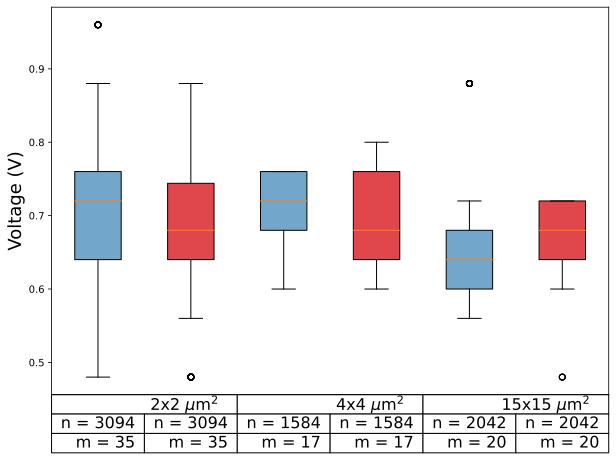

In [7]:
# creates the box and whisker plot
fig, ax = plt.subplots(figsize =(10, 7))
 
# Creating plot
title = "All Sizes, All Doping"
# ax.set_title(title)
ax.set_ylabel('Voltage (V)', fontsize=18)
box = plt.boxplot(data, patch_artist=True)
font = {'size': 16 }
matplotlib.rc('font', **font)

# colors for the plot in rgb
# values must be between 0 and 1
red = [224/255, 71/255, 76/255]
blue = [114/255, 166/255, 202/255]

colors = [blue, red, blue, red, blue, red, blue, red, blue, red, blue, red, blue, red]
 
for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)

# create text labels for the table at the bottom
cell_text = [sizesToGraph]
the_table = plt.table(cellText=cell_text,bbox = [0, -0.05, 1, 0.05])
cell_text = []
# for x in range(len(allSizes)):
#     cell_text.append("vth")
#     cell_text.append("vho")
# print([cell_text])
holdText = r"$v_\mathrm{h}$"
treshText = r"$v_\mathrm{th}$"
cell_text = [[treshText, holdText,treshText, holdText,treshText, holdText]]
the_table2 = plt.table(cellText=cell_text,bbox = [0, -0.1, 1, 0.0])

cell_text = [[nValues[0], nValues[1], nValues[2], nValues[3], nValues[4], nValues[5] ]]
the_table3 = plt.table(cellText=cell_text,bbox = [0, -0.1, 1, 0.05])


cell_text = [[mValues[0], mValues[1], mValues[2], mValues[3], mValues[4], mValues[5] ]]
the_table4 = plt.table(cellText=cell_text,bbox = [0, -0.15, 1, 0.05])

cells = the_table.properties()["celld"]
print(cells)
for i in range(0, 3):
    cells[0, i]._loc = 'center'
    
cells = the_table2.properties()["celld"]
for i in range(0, 6):
    cells[0, i]._loc = 'center'

cells = the_table3.properties()["celld"]
for i in range(0, 6):
    cells[0, i]._loc = 'center'

cells = the_table4.properties()["celld"]
for i in range(0, 6):
    cells[0, i]._loc = 'center'

# nValues = []
# for x in range(len(negativeVoltages)):
#     nValues.append("n = " + str(len(negativeVoltages[x].vThresh)))
    
# mValues = []
# for x in range(len(negativeVoltages)):
#     mValues.append("m = 100")

# cell_text = [[nValues[0], nValues[1], nValues[2], nValues[3], nValues[4] ]]
# plt.table(cellText=cell_text,bbox = [0, -0.15, 1, 0.05])

# cell_text = [[mValues[0], mValues[1], mValues[2], mValues[3], mValues[4] ]]
# plt.table(cellText=cell_text,bbox = [0, -0.2, 1, 0.05])

plt.xticks([])
# show plot
plt.savefig("final " + title + r'.pdf', bbox_inches = 'tight')
plt.show() 


In [8]:
voltageToAnalyse = 0.4
voltageRange = 0.05

data = []

for size in allSizes:
    resistancesForSize = []
    for y in range(len(files)):
        resistances = np.abs(np.divide(files[y].V, files[y].I))
        
        for x in range(len(resistances)):
            minVoltage = voltageToAnalyse - voltageRange
            maxVoltage = voltageToAnalyse + voltageRange
            if  files[y].V[x] >= minVoltage and files[y].V[x] <= maxVoltage:
                resistancesForSize.append(resistances[x])
    data.append(resistancesForSize)

In [9]:
# # creates the box and whisker plot
# fig, ax = plt.subplots(figsize =(10, 7))
 
# # Creating plot
# title = "Resistances Per Size (Our Data)"
# ax.set_title(title)
# ax.set_ylabel('Resistance (Ohm)')
# box = plt.boxplot(data, patch_artist=True)

# # colors for the plot in rgb
# # values must be between 0 and 1
# red = [224/255, 71/255, 76/255]
# blue = [114/255, 166/255, 202/255]

# colors = [blue, red, blue, red, blue, red, blue, red, blue, red, blue, red, blue, red]
 
# for patch, color in zip(box['boxes'], colors):
#     patch.set_facecolor(color)

# # create text labels for the table at the bottom
# cell_text = [allSizes]
# plt.table(cellText=cell_text,bbox = [0, -0.05, 1, 0.05])
# cell_text = []

# cell_text = [["vth", "vho", "vth", "vho", "vth", "vho", "vth", "vho", "vth", "vho", "vth", "vho", "vth", "vho"]]
# plt.table(cellText=cell_text,bbox = [0, -0.1, 1, 0.05])


# plt.xticks([])
# # show plot
# # plt.savefig(title + r'.pdf', bbox_inches = 'tight')

# # print(np.mean(data[0]))
# # print(np.mean(data[1]))
# # print(np.mean(data[2]))
# # print(np.mean(data[3]))
# # print(np.mean(data[4]))
# # print(np.mean(data[5]))
# plt.show() 


In [10]:
# creates the box and whisker plot
data = []

# go though all the files and sizes and if they match, add them to their index in data to be plotted
for dop in allDoping:
    threshVoltage = []
    holdVoltage = []
    for file in files:
        # stores "2x2" data and sorts them by doping amount
        if file.doping == dop and file.size == "2x2":
            threshVoltageArray = np.concatenate((file.posThreshValuesVoltage, file.negThreshValuesVoltage), axis=0)
            threshVoltageArray = np.absolute(threshVoltageArray)
            threshVoltage = np.append(threshVoltage, threshVoltageArray)
            holdVoltageArray = np.concatenate((file.posHoldValuesVoltage, file.negHoldValuesVoltage), axis=0)
            holdVoltageArray = np.absolute(holdVoltageArray)
            holdVoltage = np.append(holdVoltage, holdVoltageArray)
    data.append(threshVoltage)
    data.append(holdVoltage)

sizesToGraph = []

sizesToGraph.append("0%")
sizesToGraph.append("1%")
sizesToGraph.append("1.8%")

mValues = []
nValues = []

m2x2 = 0
m4x4 = 0
m15x15 = 0

n2x2 = 0
n4x4 = 0
n15x15 = 0

# print(allSizes)

for x in files:
    if "2x2" in x.size and x.doping == 0:
        m2x2 += 1
        n2x2 += round(len(x.zeroIndexes) / 2)
    if "2x2" in x.size and x.doping == 5:
        m4x4 += 1
        n4x4 += round(len(x.zeroIndexes) / 2)
    if "2x2" in x.size and x.doping == 10:
        m15x15 += 1
        n15x15 += round(len(x.zeroIndexes) / 2)
     
print(m2x2, m4x4, m15x15)
print(n2x2, n4x4, n15x15)

mValues.append("m = " + str(m2x2))
mValues.append("m = " + str(m2x2))
mValues.append("m = " + str(m4x4))
mValues.append("m = " + str(m4x4))
mValues.append("m = " + str(m15x15))
mValues.append("m = " + str(m15x15))

nValues.append("n = " + str(n2x2))
nValues.append("n = " + str(n2x2))
nValues.append("n = " + str(n4x4))
nValues.append("n = " + str(n4x4))
nValues.append("n = " + str(n15x15))
nValues.append("n = " + str(n15x15))

17 8 10
1314 802 978


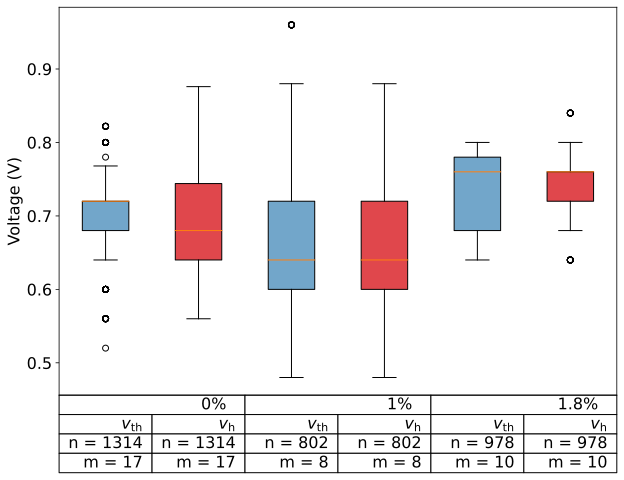

In [11]:
# print(data)
fig, ax = plt.subplots(figsize =(10, 7))

# Creating plot
box = plt.boxplot(data, patch_artist=True)

red = [224/255, 71/255, 76/255]
blue = [114/255, 166/255, 202/255]

colors = [blue, red, blue, red, blue, red, blue, red, blue, red, blue, red, blue, red]
 
for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)

title = "2x2 All Doping"
# ax.set_title(title)
ax.set_ylabel('Voltage (V)')

# Plot bars and create text labels for the table
cell_text = [sizesToGraph]
the_table = plt.table(cellText=cell_text,bbox = [0, -0.05, 1, 0.05])

holdText = r"$v_\mathrm{h}$"
treshText = r"$v_\mathrm{th}$"
cell_text = [[treshText, holdText,treshText, holdText,treshText, holdText]]
the_table2 = plt.table(cellText=cell_text,bbox = [0, -0.1, 1, 0.05])

cell_text = [[nValues[0], nValues[1], nValues[2], nValues[3], nValues[4], nValues[5] ]]
the_table3 = plt.table(cellText=cell_text,bbox = [0, -0.15, 1, 0.05])

cell_text = [[mValues[0], mValues[1], mValues[2], mValues[3], mValues[4], mValues[5] ]]
the_table4 = plt.table(cellText=cell_text,bbox = [0, -0.2, 1, 0.05])

cells = the_table.properties()["celld"]
for i in range(0, 3):
    cells[0, i]._loc = 'center'
    
cells = the_table2.properties()["celld"]
for i in range(0, 6):
    cells[0, i]._loc = 'center'

cells = the_table3.properties()["celld"]
for i in range(0, 6):
    cells[0, i]._loc = 'center'

cells = the_table4.properties()["celld"]
for i in range(0, 6):
    cells[0, i]._loc = 'center'

plt.xticks([])
# show plot
plt.savefig("final " + title + r'.pdf', bbox_inches = 'tight')
plt.show()

In [12]:
# mypath = r"C:\Users\Ted Mburu\NbO2\Doping0"
# onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f))]
# print(onlyfiles)
# # C:\Users\Ted Mburu\NbO2

data = []

# go though all the files and sizes and if they match, add them to their index in data to be plotted
for size in allSizes:
    threshVoltage = []
    holdVoltage = []
    for file in files:
        if file.size == size and file.doping == 0:
            threshVoltageArray = np.concatenate((file.posThreshValuesVoltage, file.negThreshValuesVoltage), axis=0)
            threshVoltageArray = np.absolute(threshVoltageArray)
            threshVoltage = np.append(threshVoltage, threshVoltageArray)
            holdVoltageArray = np.concatenate((file.posHoldValuesVoltage, file.negHoldValuesVoltage), axis=0)
            holdVoltageArray = np.absolute(holdVoltageArray)
            holdVoltage = np.append(holdVoltage, holdVoltageArray)

        
#         if len(threshVoltage) > 0:
#             print(threshVoltage)
#             for z in range(1, len(threshVoltage)):
#                 threshVoltage = np.concatenate((threshVoltage[0], threshVoltage[z]), axis=0)

#         if len(holdVoltage) > 0:
#             for z in range(1, len(holdVoltage)):
#                 holdVoltage = np.concatenate((holdVoltage[0], holdVoltage[z]), axis=0)
    data.append(threshVoltage)
    data.append(holdVoltage)
#     print(data[0])

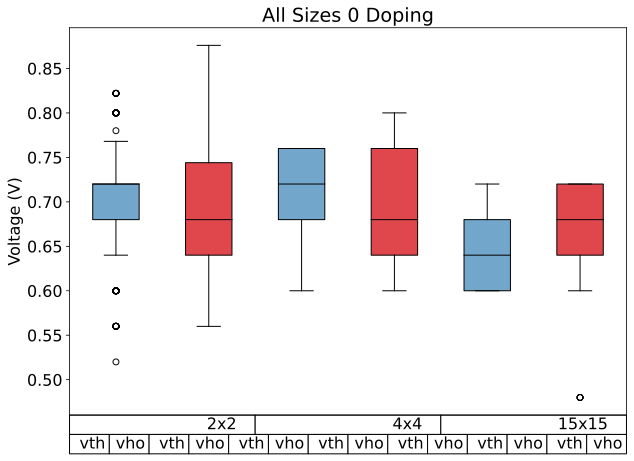

In [13]:
# print(data)
fig, ax = plt.subplots(figsize =(10, 7))
 
# Creating plot
title = "All Sizes 0 Doping"
ax.set_title(title)
ax.set_ylabel('Voltage (V)')
box = plt.boxplot(data, patch_artist=True)

red = [224/255, 71/255, 76/255]
blue = [114/255, 166/255, 202/255]

colors = [blue, red, blue, red, blue, red, blue, red, blue, red, blue, red, blue, red]
 
for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)

# Plot bars and create text labels for the table
cell_text = [allSizes]
plt.table(cellText=cell_text,bbox = [0, -0.05, 1, 0.05])
cell_text = []
# for x in range(len(allSizes)):
#     cell_text.append("vth")
#     cell_text.append("vho")
# print([cell_text])
cell_text = [["vth", "vho", "vth", "vho", "vth", "vho", "vth", "vho", "vth", "vho", "vth", "vho", "vth", "vho"]]
plt.table(cellText=cell_text,bbox = [0, -0.1, 1, 0.05])

for median in box['medians']:
    median.set_color('black')

# nValues = []
# for x in range(len(negativeVoltages)):
#     nValues.append("n = " + str(len(negativeVoltages[x].vThresh)))
    
# mValues = []
# for x in range(len(negativeVoltages)):
#     mValues.append("m = 100")

# cell_text = [[nValues[0], nValues[1], nValues[2], nValues[3], nValues[4] ]]
# plt.table(cellText=cell_text,bbox = [0, -0.15, 1, 0.05])

# cell_text = [[mValues[0], mValues[1], mValues[2], mValues[3], mValues[4] ]]
# plt.table(cellText=cell_text,bbox = [0, -0.2, 1, 0.05])

plt.xticks([])
plt.savefig(title + r'.pdf', bbox_inches = 'tight')
# show plot
plt.show() 
